In [1]:
# import paackages for data processing and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.style.use({'figure.figsize':(20,16)})
plt.rcParams['font.sans-serif']=['SimHei']  
plt.rcParams['axes.unicode_minus']=False

In [2]:
# load dataset
# For demostration purpose, just use one station as example
df = pd.read_csv('dataset-gru.csv', names=['density'])

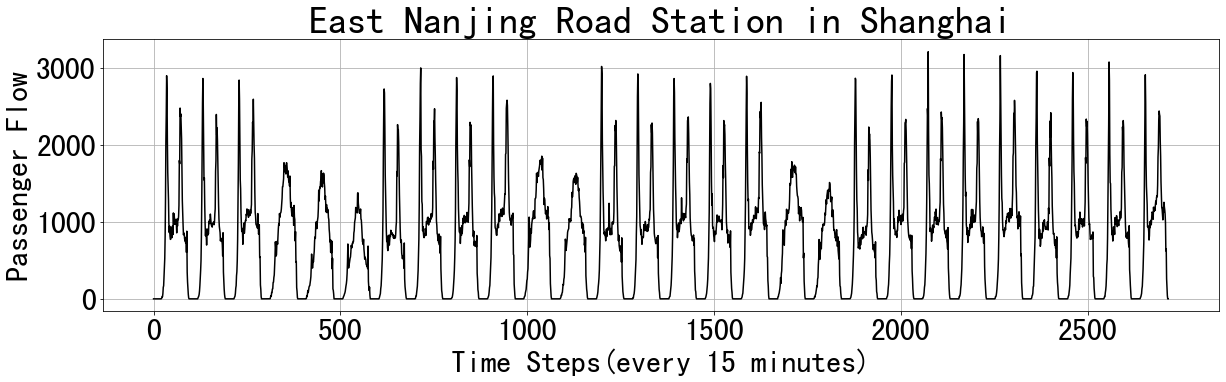

In [3]:
# visualize passenger flow data
# Subway card swipe data(original dataset) -> passenger flow data (every 15 minutes)
df['density'].plot(style='k-', figsize=(20,5))
plt.tick_params(labelsize=30)
plt.grid()
plt.ylabel('Passenger Flow',fontsize=30)
plt.xlabel('Time Steps(every 15 minutes)',fontsize=30)
plt.title('East Nanjing Road Station in Shanghai', fontsize=38)
plt.show()

# GRU model

In [4]:
# data preprocessing functions
train_data = df[0:int(len(df['density'])*0.8)]
test_data = df[int(len(df['density'])*0.8):]
mean = train_data['density'].mean()
std = train_data['density'].std()
def preprocessing(data):
    # min-max preprocesing
    processed_ls = []
    for num_str in data:
        num = float(num_str)
        processed_ls.append((num-mean)/std)
    return processed_ls
def reverse_preprocessing(data):
    reversed_ls = []
    for num in data:
        reversed_ls.append(num*std + mean)
    return reversed_ls

In [5]:
# load and split dataset for training and testing
import numpy as np
def load_data(filename, seq_len):
    f = open(filename, 'r').read() # read file
    data = f.split('\n')
    data = preprocessing(data)
    sequence_lenghth = seq_len + 1 # sequence length plus 1 as the label
    result = []
    for index in range(len(data)-sequence_lenghth):
        result.append(data[index : index+sequence_lenghth]) # gernerate dataset for modelling
    result = np.array(result) 
    split_row = round(0.8*result.shape[0]) # 80% for training
    train = result[:split_row, :]
    x_train = train[:, :-1] 
    y_train = train[:, -1] 
    x_test = result[split_row:, :-1] 
    y_test = result[split_row:, -1] 
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) # last 1-dimension means is for a each data number
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    # print(split_row)
    return [x_train, y_train, x_test, y_test, data]
x_train, y_train, x_test, y_test, data = load_data('dataset-gru.csv', 3)

In [6]:
# build GRU model for time-series prediction
# As we set in this experiment, 
# we predict passenger flow in next time step using  three-period lagged data(last three time steps)
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GRU
from tensorflow.keras.models import Sequential
# design network
model = Sequential()
model.add(GRU(100, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


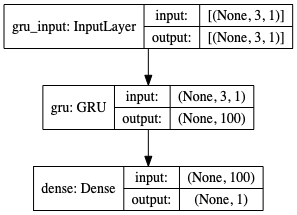

In [7]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='GRUmodel.png',show_shapes=True)

In [8]:
# training process
model.fit(x_train, y_train, epochs=100, batch_size=72, validation_data=(x_test, y_test), verbose=2, shuffle=False)

Train on 2170 samples, validate on 542 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
2170/2170 - 1s - loss: 0.3346 - val_loss: 0.2351
Epoch 2/100
2170/2170 - 0s - loss: 0.1584 - val_loss: 0.1898
Epoch 3/100
2170/2170 - 0s - loss: 0.1391 - val_loss: 0.1684
Epoch 4/100
2170/2170 - 0s - loss: 0.1217 - val_loss: 0.1434
Epoch 5/100
2170/2170 - 0s - loss: 0.0997 - val_loss: 0.1114
Epoch 6/100
2170/2170 - 0s - loss: 0.0773 - val_loss: 0.0876
Epoch 7/100
2170/2170 - 0s - loss: 0.0653 - val_loss: 0.0761
Epoch 8/100
2170/2170 - 0s - loss: 0.0572 - val_loss: 0.0689
Epoch 9/100
2170/2170 - 0s - loss: 0.0519 - val_loss: 0.0635
Epoch 10/100
2170/2170 - 0s - loss: 0.0477 - val_loss: 0.0584
Epoch 11/100
2170/2170 - 0s - loss: 0.0443 - val_loss: 0.0540
Epoch 12/100
2170/2170 - 0s - loss: 0.0414 - val_loss: 0.0500
Epoch 13/100
2170/2170 - 0s - loss: 0.0390 - val_loss: 0.0466
Epoch 14/100
2170/2170 - 0s - loss: 0.0374 - val_loss: 0.0441


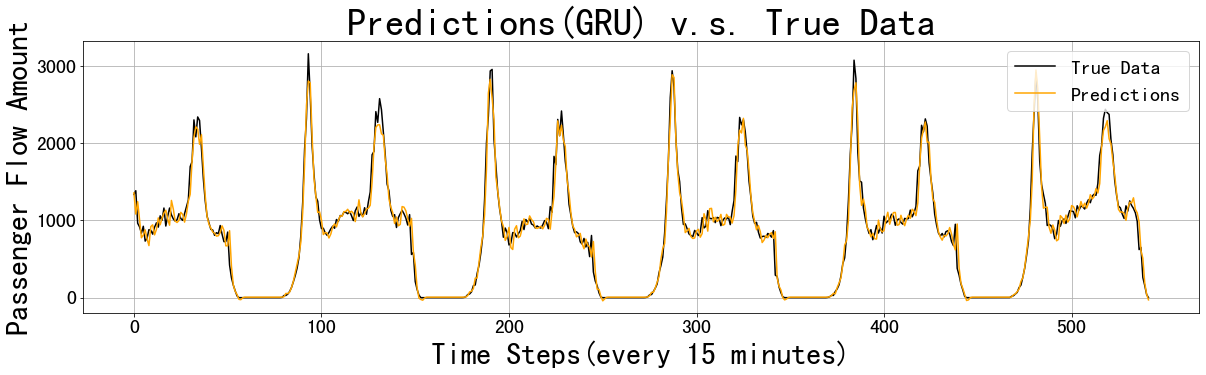

In [9]:
# do predictions on test dataset and visualize the predictions against true data
def get_predictions(model, data):
    predictions = model.predict(data)
    predictions = np.reshape(predictions, (predictions.size,)) 
    return predictions
def plot_results(predictions, y_test):
    plt.style.use({'figure.figsize':(20,5)})
    plt.plot(y_test, 'k', label='True Data')
    plt.plot(predictions, 'orange', label='Predictions')
    plt.tick_params(labelsize=20)
    plt.legend(fontsize=20, markerscale=10, loc='upper right')
    plt.grid()
    plt.xlabel('Time Steps(every 15 minutes)', fontsize=30)
    plt.ylabel('Passenger Flow Amount', fontsize=30)
    plt.title('Predictions(GRU) v.s. True Data', fontsize=38)
predictions = reverse_preprocessing(get_predictions(model, x_test))
true_data = reverse_preprocessing(np.reshape(y_test, (y_test.size,)) )
plot_results(predictions, true_data)

In [10]:
# another visualization for better demostration
from pyecharts.charts import Line
from pyecharts import options as opts
x_index = [i for i in range(len(true_data))]
line = (Line()
       .add_xaxis(x_index)
        .add_yaxis('True Data', true_data, 
                  is_symbol_show=False,
                  is_smooth=True, 
                 )
        .add_yaxis('Predictions', predictions, 
                  is_symbol_show=False,
                  is_smooth=True, 
                 )
       .set_global_opts(title_opts=opts.TitleOpts(title="Predictions of GRU model", subtitle="East Nanjing Road"))
      )
line.render_notebook()

In [11]:
# Evaluations metrics
def MSE(yhat,y):
    error = np.array(yhat - y)
    error_power = np.power(error, 2)
    MSE_error = np.sum(error_power)/len(y)
    return MSE_error
def RMSE(yhat,y):
    return MSE(yhat,y)**0.5
def RSquare(yhat,y):
    return 1 - MSE(yhat,y)/ np.var(yhat)
def MAE(yhat, y):
    error = np.array(yhat-y)
    error_ab = np.fabs(error)
    MAE_error = np.sum(error_ab)/len(y)
    return MAE_error

In [12]:
f = lambda data : data*std + mean # reverse min-max
pred = model.predict(x_test)
pred = f(pred.reshape((1,len(pred))))
true = f(y_test)

In [13]:
print("--------Evaluation Metrics--------")
print("RMSE: ", RMSE(pred, true))
print("MAE: ", MAE(pred, true))
print("R-Square", RSquare(pred, true))
# df.describe()

--------Evaluation Metrics--------
RMSE:  122.47571420995482
MAE:  77.41440495001876
R-Square 0.9684984400950362
